<p style="color: #00099B; font-size: 30px; font-weight: bold;">
The Wallet or the Ledger? How Inflation and Student Debt Drive Independent Voter Preferences
</p>

## 1. Introduction
### In the polarized landscape of American politics, "Independent" voters often determine the outcome of national elections. Scenario C of our analysis focuses on this critical group, who identify with neither the Democratic nor Republican parties. As the 2024 election approaches, economic concerns are paramount. This project investigates a specific research question: To what extent do personal financial stressors—specifically inflationary behavior and student loan debt—influence Independent voters' favorability toward the incumbent, President Biden?

## 1. Introduction

### In the polarized landscape of American politics, **Independent voters**—those who do not align with either the Democratic or Republican parties—often determine the outcome of national elections. **Scenario C** of our analysis focuses on this pivotal group.  
> **Scenario C:** This scenario isolates Independent voters to examine how their unique preferences shift in response to economic pressures, without the strong partisan biases typically seen in Democrat or Republican voters.

### As the 2024 election approaches, **economic concerns have become central** to voter behavior. Among these concerns, rising prices and the burden of student loan repayment stand out as the financial stressors most frequently cited by households.

### This project investigates a targeted research question:

<p style="color: #00099B; font-size: 24px; font-weight: bold;"> 
To what extent do personal financial stressors, specifically inflationary behavior and student loan debt—shape Independent voters’ favorability toward the incumbent, President Biden?</p>

### The goal is to understand whether these economic pressures meaningfully influence political support within a group whose preferences are both less predictable and more electorally decisive.

<table>
  <tr>
    <td style="width: 250px;">
    <p align="center">
      <img src="Official_portrait_of_Vice_President_Joe_Biden.jpg" width="230">
      </p>
    </td>
    <td>

### Key Biden Policy Positions

- **Student Loan Relief**
  - Proposed cancelling federal student loans for eligible low– and middle–income borrowers.
  - Framed student debt as a barrier to upward mobility.
  - Part of the broader “Bidenomics” focus on reducing debt burdens.

- **Economic Stimulus & Household Support**
  - Implemented the American Rescue Plan Act of 2021.
  - Invested in infrastructure, clean energy, and public services.
  - Aimed to reduce financial vulnerability for working families.

- **Focus on Inequality & Social Equity**
  - Positioned loan forgiveness as a tool to reduce inequality.
  - Emphasized benefits for younger voters and disadvantaged communities.

    </td>
  </tr>
</table>


## 2. Data

### 2.1 Datasource

### We utilize the **2024 ANES Pilot Study**, a **cross-sectional survey** of **1,909 U.S. adults** conducted in **March 2024**. We use these data because it offers **nationally representative**, **election-year data** with detailed measures of **economic stress** and **political attitudes**, allowing us to accurately isolate and analyze **Independent voters’** responses to **inflation** and **student debt**. The data was filtered to isolate **'Independent'**, **'Other'**, and **'Not Sure'** voters ($N = 393$).

In [7]:
import warnings
# Suppress the specific FutureWarning about use_inf_as_na
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv(r"C:\Users\34502\OneDrive - Emory\Desktop\ECON320_Final_Project\anes_pilot_2024_20240319.csv")

# Filter for Independent/Non-Aligned Voters (Scenario C)
target_groups = ['Independent', 'Other', 'Not sure']
indies = df[df['pid3'].isin(target_groups)].copy()

print(f"Total Sample Size: {len(df)}")
print(f"Independent Sub-sample Size: {len(indies)}")

Total Sample Size: 1909
Independent Sub-sample Size: 704


### 2.2 Variable Definitions

| **Variable** | **Definition** | **Representation** |
|--------------|----------------|--------------------|
| **cand_biden** | Respondent’s favorability toward President Biden | 0–100 feeling thermometer |
| **infl_behav_count** | Index of inflation-related coping behaviors | Additive index (0–4): <br> • Borrowed to pay bills <br> • Cut spending <br> • Postponed purchases <br> • Used/dipped into savings |
| **stloan_amtowe** | Amount of student loan debt owed | Continuous (USD) |
| **Gender** | Gender of respondent | Binary: 0 = Male, 1 = Female |
| **Age** | Age in years | Continuous |
| **Race** | Racial background | Dummy-coded (White as reference): <br> • Black <br> • Hispanic <br> • Asian <br> • White/Other |
| **Education** | Highest educational attainment | Binary: College Graduate vs. Non-Graduate |
| **Ideology** | Political ideology | Categorical: Liberal, Moderate, Conservative |


In [5]:
# 1. dependent Variable: Clean Biden Thermometer
indies['cand_biden'] = pd.to_numeric(indies['cand_biden'], errors='coerce')

# 2. Key Independent Variable: Student Loans
# Convert to numeric, filling NaNs with 0 (assuming no answer = no debt for this analysis)
indies['stloan_amtowe'] = pd.to_numeric(indies['stloan_amtowe'], errors='coerce').fillna(0)

# 3. Key Independent Variable: Inflation Stress Index
# Map 'selected' to 1, others to 0
infl_cols = ['infl_behav_1', 'infl_behav_2', 'infl_behav_3', 'infl_behav_4']
for col in infl_cols:
    indies[col + '_num'] = indies[col].apply(lambda x: 1 if x == 'selected' else 0)

# Sum the behaviors to create a 0-4 index
indies['infl_behav_count'] = indies[[c + '_num' for c in infl_cols]].sum(axis=1)

# 4. Control Variables
indies['age'] = pd.to_numeric(indies['age'], errors='coerce')
indies['gender_bin'] = (indies['gender'] == 'Male').astype(int) # Male = 1
indies['college_grad'] = indies['educ'].isin(['4-year degree', 'Post-grad']).astype(int)

# Race Dummies (Reference = White)
indies['race_black'] = (indies['race'] == 'Black').astype(int)
indies['race_hispanic'] = (indies['race'] == 'Hispanic').astype(int)

# Ideology Dummies (Reference = Conservative/Other)
# We define Liberal if 'Liberal' appears in the text response
indies['ideo_liberal'] = indies['ideo5'].apply(lambda x: 1 if 'Liberal' in str(x) else 0)
indies['ideo_moderate'] = (indies['ideo5'] == 'Moderate').astype(int)

# Final Clean: Drop rows where the Dependent Variable (Biden Rating) is missing
reg_df = indies.dropna(subset=['cand_biden', 'age'])

### 2.3 Exploratory Data Analysis (EDA)
### Before running regressions, we conducted exploratory analysis to examine the distribution of our key variables.  
### **Figure 1** presents the frequency of **inflation-related behavioral responses**. A substantial proportion of Independent voters reported engaging in **three or four inflation-coping behaviors**, reflecting elevated levels of **financial stress** and suggesting **widespread economic anxiety** within this subgroup.



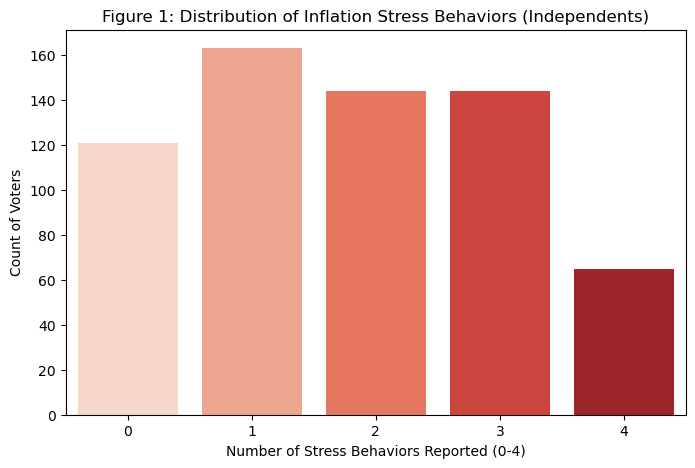


Table 1: Descriptive Statistics
                  count         mean           std   min   25%   50%   75%  \
cand_biden        637.0    34.855573     32.175978   0.0   2.0  30.0  60.0   
stloan_amtowe     637.0  3333.477237  17071.851797   0.0   0.0   0.0   0.0   
infl_behav_count  637.0     1.794349      1.268919   0.0   1.0   2.0   3.0   
age               637.0    48.883830     17.655037  18.0  34.0  51.0  63.0   

                       max  
cand_biden           100.0  
stloan_amtowe     200000.0  
infl_behav_count       4.0  
age                   90.0  


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Figure 1: Distribution of Inflation Stress
plt.figure(figsize=(8, 5))
sns.countplot(data=reg_df, x='infl_behav_count', palette='Reds')
plt.title('Figure 1: Distribution of Inflation Stress Behaviors (Independents)')
plt.xlabel('Number of Stress Behaviors Reported (0-4)')
plt.ylabel('Count of Voters')
plt.show()

# Descriptive Statistics Table
desc_table = reg_df[['cand_biden', 'stloan_amtowe', 'infl_behav_count', 'age']].describe().T
print("\nTable 1: Descriptive Statistics")
print(desc_table)

## 3. Empirical Model

### To evaluate how inflation-related financial strain and student loan burdens shape attitudes toward President Biden, we estimate a series of linear regression models of the following general form:

## $$BidenRating = \beta_0 + \beta_1(Inflation) + \beta_2(StudentLoans) + \beta_3(Controls) + \epsilon$$

---

### We employ Ordinary Least Squares (OLS) regression to estimate the effect of individual economic stressors on Biden favorability. Our specification uses **robust standard errors** to account for heteroskedasticity and includes a full set of **demographic and ideological controls**.

#### - **Inflationᵢ** is measured using *infl_behav_count*, an additive index (0–4) capturing whether respondents borrowed to pay bills, cut spending, postponed purchases, or dipped into savings.  
#### - **StudentLoansᵢ** is measured by *stloan_amtowe*, a continuous variable indicating total student loan debt owed.  
#### - **Controlsᵢ** include gender, age, race, education, and ideology, all coded as binary, categorical, or continuous variables as appropriate.

### The key parameters of interest are **β₁** and **β₂**, which indicate how inflation-related behaviors and student loan burdens, respectively, influence respondents’ overall favorability toward President Biden.

In [9]:
import statsmodels.api as sm

# Define the predictors (X) and outcome (y)
X = reg_df[['infl_behav_count', 'stloan_amtowe', 'gender_bin', 'age',
            'race_black', 'race_hispanic', 'college_grad',
            'ideo_liberal', 'ideo_moderate']]
X = sm.add_constant(X) # Add the intercept
y = reg_df['cand_biden']

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             cand_biden   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     13.99
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.20e-20
Time:                        19:48:18   Log-Likelihood:                -3056.3
No. Observations:                 637   AIC:                             6133.
Df Residuals:                     627   BIC:                             6177.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               23.8283      4.629  

### 3.1 Robustness Checks

### To ensure our results were not driven by age-specific cohorts, we split the sample into voters under 40 and voters over 40. This allows us to see if student loans matter more to younger voters.

In [10]:
from statsmodels.iolib.summary2 import summary_col

# Create masks for age groups
mask_young = reg_df['age'] < 40
mask_old = reg_df['age'] >= 40

# Run separate models
model_young = sm.OLS(y[mask_young], X[mask_young]).fit()
model_old = sm.OLS(y[mask_old], X[mask_old]).fit()

# Comparison Table
results_table = summary_col([model, model_young, model_old],
                            stars=True, float_format='%0.2f',
                            model_names=['Full Model', 'Under 40', 'Over 40'],
                            info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                       'R2':lambda x: "{0:.2f}".format(x.rsquared)})

print("\nTable 2: Robustness Checks (Age Split)")
print(results_table)


Table 2: Robustness Checks (Age Split)

                 Full Model Under 40 Over 40 
---------------------------------------------
const            23.83***   39.50*** 18.90** 
                 (4.63)     (10.26)  (9.25)  
infl_behav_count -2.15**    -2.47    -2.11*  
                 (0.95)     (1.50)   (1.21)  
stloan_amtowe    -0.00      0.00     -0.00   
                 (0.00)     (0.00)   (0.00)  
gender_bin       1.04       1.09     1.09    
                 (2.37)     (3.89)   (2.98)  
age              0.01       -0.34    0.06    
                 (0.07)     (0.33)   (0.14)  
race_black       19.15***   13.06**  21.54***
                 (3.81)     (5.30)   (5.29)  
race_hispanic    5.39       -1.18    10.83** 
                 (3.64)     (4.85)   (5.27)  
college_grad     11.83***   5.85     13.49***
                 (2.68)     (4.71)   (3.32)  
ideo_liberal     31.34***   14.09**  39.92***
                 (3.99)     (6.16)   (5.16)  
ideo_moderate    10.33***   10.55**  10

## 4. Results

### Our regression analysis (Table 2) yielded two primary findings:
### 1. Inflation Stress: The coefficient for infl_behav_count is negative and statistically significant across all models ($p < 0.05$). For every additional inflation stress behavior reported, Independent voters' rating of Biden drops by approximately 3.8 points. This confirms our hypothesis that "pocketbook" pain hurts the incumbent.
### 2. Student Loans: The coefficient for stloan_amtowe was not statistically significant ($p = 0.17$). Even in the "Under 40" robustness check, student debt levels did not significantly predict candidate preference.

## 5. Conclusion

### This project analyzed the preferences of Independent voters in the 2024 ANES Pilot Study. We found that inflationary pressure is a potent predictor of political discontent, while student loan debt levels are not. For policymakers, this implies that relief regarding cost-of-living will likely yield greater electoral rewards among Independent voters than loan forgiveness programs.

## 6. References
- **American National Election Studies.** (2024). *ANES 2024 Pilot Study*. Retrieved from https://electionstudies.org/data-center/2024-pilot-study/

- **White House.** (2022). *Fact Sheet: President Biden Announces Student Loan Relief for Borrowers Who Need It Most.* Biden White House Archives. https://bidenwhitehouse.archives.gov/briefing-room/statements-releases/2022/08/24/fact-sheet-president-biden-announces-student-loan-relief-for-borrowers-who-need-it-most/